In [10]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import seaborn as sns 

In [11]:
def create_a_dataset():
    np.random.seed(42)
    n_samples = 200

    # Independent base features
    A = np.random.normal(0, 1, n_samples)
    B = np.random.normal(0, 1, n_samples)
    C = np.random.normal(0, 1, n_samples)

    # Construct features that are combinations but with less obvious pairwise correlation
    X1 = A + np.random.normal(0, 1, n_samples)
    X2 = B + np.random.normal(0, 1, n_samples)
    X3 = C + np.random.normal(0,  1, n_samples)

    # Create complex collinearity: X4 ≈ X1 + X2, X5 ≈ X2 + X3, X6 ≈ X1 + X3
    X4 = X1 + X2 + np.random.normal(0, 1, n_samples)
    X5 = X2 + X3 + np.random.normal(0,  1, n_samples)
    X6 = X1 + X3 + np.random.normal(0,  1, n_samples)

    # Target depends on X1 and X3
    y = X1 +  X3 + np.random.normal(0, 1, n_samples)

    # Create DataFrame
    dataset = pd.DataFrame({
        'X1': X1, 'X2': X2, 'X3': X3,
        'X4': X4, 'X5': X5, 'X6': X6,
        'y': y
    })



    # Features (alle Spalten außer der letzten)
    X = dataset.iloc[:, :-1]

    # Target (die letzte Spalte)
    y = dataset.iloc[:, -1]
    return X,y
X,y = create_a_dataset()


In [12]:
from sklearn.preprocessing import StandardScaler

# Initialize scaler
scaler = StandardScaler()

# Fit and transform X
X = scaler.fit_transform(X)

X = pd.DataFrame(X)

Features to be dropped due to high correlation with other feature: []


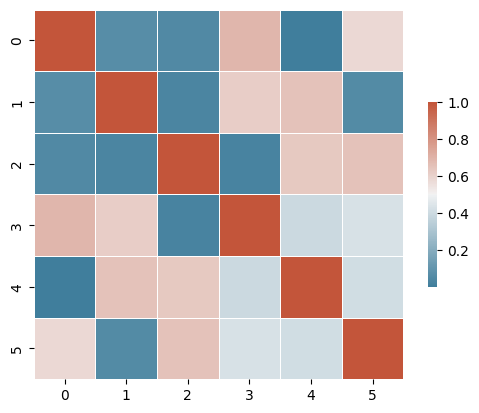

In [13]:
# preprcess data
def multicollinearity_eliminator(numerical_data,threshold = 0.7):
        
        '''
        Remove multicollinearity among the dataset features
        
        Parameters: 
        - numerical_data : Numeric features of the dataset
        - threshold : the value indicates that if the features are X% correlated, drop them. Can be altered based on the requirements
        '''
        corr_matrix = numerical_data.corr().abs()
        sns.heatmap(corr_matrix,cmap=sns.diverging_palette(230, 20, as_cmap=True),square=True, linewidths=.5, cbar_kws={"shrink": .5})
        upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape),k=1).astype(np.bool_))
        features_to_drop = [col for col in upper.columns if any(upper[col] >= threshold)]
        print("Features to be dropped due to high correlation with other feature:",features_to_drop)
        numerical_data = numerical_data.drop(columns=features_to_drop)

        return numerical_data

X = multicollinearity_eliminator(X.select_dtypes(include=['int64', 'float64']))

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

In [ ]:
# Train a simple normal Linear Regression Model
from sklearn.metrics import mean_squared_error

lr = LinearRegression().fit(X_train, y_train)


y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)

print(f"Linear Regression - Training MSE: {mean_squared_error(y_train, y_train_pred):.4f}")
print(f"Linear Regression - Test MSE:     {mean_squared_error(y_test, y_test_pred):4f}")

Linear Regression - Training MSE: 0.8563
Linear Regression - Test MSE:     1.306368


We have overfitting as MSE is much higher on test

In [25]:
from sklearn.linear_model import Ridge

ridge = Ridge(alpha=1).fit(X_train, y_train)

y_train_pred = ridge.predict(X_train)
y_test_pred = ridge.predict(X_test)



print(f"Ridge Regression - Training MSE: {mean_squared_error(y_train, y_train_pred):.4f}")
print(f"Ridge Regression - Test MSE:     {mean_squared_error(y_test, y_test_pred):.4f}")

Ridge Regression - Training MSE: 0.8579
Ridge Regression - Test MSE:     1.2753


A ridge regression with alpha/lambda reduces overfitting and improves quality on test.

But which alpha is the best?

### 🧠 **What the next Code Does**

In this code, we apply **Ridge Regression** (a regularized form of linear regression) to a small dataset in order to prevent overfitting. We:

1. Use **5-fold cross-validation** to evaluate model performance for different values of the regularization parameter `alpha`.
2. For each alpha, we calculate the **Mean Squared Error (MSE)** on the validation fold and store the results.
3. After testing all alpha values, we select the one with the **lowest average MSE** across folds.
4. Finally, we train a Ridge model on the **entire training set using the best alpha from cross validation**, make predictions, and evaluate its performance on both training and test data.


In [23]:
import numpy as np
import pandas as pd
from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

# Convert DataFrames to NumPy arrays
X_array = X_train.values
y_array = y_train.values

# Define the list of regularization strengths to try
alpha_values = [0.01,0.05,0.1, 0.2, 0.5, 0.75, 1, 1.5, 2, 5, 10, 20,50]

# Set up 5-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Store all MSE results and average MSE per alpha
cv_results = []
average_mse_per_alpha = {}

# Loop through each alpha value
for alpha in alpha_values:
    mse_per_fold = []

    # Perform cross-validation
    for fold_index, (train_idx, val_idx) in enumerate(kf.split(X_array), start=1):
        # Split the data
        X_train_fold, X_val_fold = X_array[train_idx], X_array[val_idx]
        y_train_fold, y_val_fold = y_array[train_idx], y_array[val_idx]

        # Train Ridge Regression model
        model = Ridge(alpha=alpha, random_state=42)
        model.fit(X_train_fold, y_train_fold)

        # Predict and calculate MSE
        y_pred_fold = model.predict(X_val_fold)
        mse = mean_squared_error(y_val_fold, y_pred_fold)

        # Save results
        mse_per_fold.append(mse)
        cv_results.append({
            'alpha': alpha,
            'fold': fold_index,
            'mse': mse
        })

    # Compute average MSE for current alpha
    average_mse_per_alpha[alpha] = np.mean(mse_per_fold)

# Print MSE results for all folds
print("Cross-validation results for each alpha and fold:")
print(pd.DataFrame(cv_results))

# Determine the best alpha (smallest average MSE)
best_alpha = min(average_mse_per_alpha, key=average_mse_per_alpha.get)
print(f"\n✅ Best alpha based on average MSE: {best_alpha}")

# Train final model on full training data with best alpha
final_model = Ridge(alpha=best_alpha, random_state=42)
final_model.fit(X_train, y_train)

# Predict on training and test sets
y_train_pred = final_model.predict(X_train)
y_test_pred = final_model.predict(X_test)

# Show training and test MSE
print(f"\n📊 Final Model Performance:")
print(f"Training MSE: {mean_squared_error(y_train, y_train_pred):.4f}")
print(f"Test MSE:     {mean_squared_error(y_test, y_test_pred):.4f}")


Cross-validation results for each alpha and fold:
    alpha  fold       mse
0    0.01     1  1.282890
1    0.01     2  1.087608
2    0.01     3  0.883461
3    0.01     4  0.657579
4    0.01     5  0.877125
..    ...   ...       ...
60  50.00     1  1.147454
61  50.00     2  1.419053
62  50.00     3  1.534254
63  50.00     4  0.774231
64  50.00     5  1.030508

[65 rows x 3 columns]

✅ Best alpha based on average MSE: 1

📊 Final Model Performance:
Training MSE: 0.8579
Test MSE:     1.2753


📌 **Observation**: The model's performance changes depending on the train-test split, which is common for small datasets.

🏆 **Best Alpha**: Based on the lowest average MSE across folds, the optimal alpha value was **1**.

📈 **Final Model Performance**:
- **Training MSE**: 0.8579
- **Test MSE**: 1.2753

This indicates that the model fits the training data reasonably well, and generalizes acceptably to the test set, considering the small sample size. And the MSE is lower with Ridge than with simple linear regression, which means regularisation helps.

In [18]:
import numpy as np
import pandas as pd
from sklearn.linear_model import Lasso, Ridge
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

# Convert DataFrames to NumPy arrays
X_array = X_train.values
y_array = y_train.values

# Define the list of regularization strengths to try
alpha_values = [0.01,0.05,0.1, 0.2, 0.5, 0.75, 1, 1.5, 2, 5, 10, 20]

# Set up 5-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Store all MSE results and average MSE per alpha
cv_results = []
average_mse_per_alpha = {}

# Loop through each alpha value
for alpha in alpha_values:
    mse_per_fold = []

    # Perform cross-validation
    for fold_index, (train_idx, val_idx) in enumerate(kf.split(X_array), start=1):
        # Split the data
        X_train_fold, X_val_fold = X_array[train_idx], X_array[val_idx]
        y_train_fold, y_val_fold = y_array[train_idx], y_array[val_idx]

        # Train Lasso Regression model
        model = Lasso(alpha=alpha, random_state=42)
        model.fit(X_train_fold, y_train_fold)

        # Predict and calculate MSE
        y_pred_fold = model.predict(X_val_fold)
        mse = mean_squared_error(y_val_fold, y_pred_fold)

        # Save results
        mse_per_fold.append(mse)
        cv_results.append({
            'alpha': alpha,
            'fold': fold_index,
            'mse': mse
        })

    # Compute average MSE for current alpha
    average_mse_per_alpha[alpha] = np.mean(mse_per_fold)

# Print MSE results for all folds
print("Cross-validation results for each alpha and fold:")
print(pd.DataFrame(cv_results))

# Determine the best alpha (smallest average MSE)
best_alpha = min(average_mse_per_alpha, key=average_mse_per_alpha.get)
print(f"\n✅ Best alpha based on average MSE: {best_alpha}")

# Train final model on full training data with best alpha
final_model = Lasso(alpha=best_alpha, random_state=42)
final_model.fit(X_train, y_train)

# Predict on training and test sets
y_train_pred = final_model.predict(X_train)
y_test_pred = final_model.predict(X_test)

# Show training and test MSE
print(f"\n📊 Final Model Performance:")
print(f"Training MSE: {mean_squared_error(y_train, y_train_pred):.4f}")
print(f"Test MSE:     {mean_squared_error(y_test, y_test_pred):.4f}")

Cross-validation results for each alpha and fold:
    alpha  fold       mse
0    0.01     1  1.174334
1    0.01     2  1.075146
2    0.01     3  0.913354
3    0.01     4  0.641930
4    0.01     5  0.881524
5    0.05     1  1.080602
6    0.05     2  1.082993
7    0.05     3  0.992542
8    0.05     4  0.574165
9    0.05     5  0.885542
10   0.10     1  1.095086
11   0.10     2  1.130185
12   0.10     3  1.060289
13   0.10     4  0.567448
14   0.10     5  0.886798
15   0.20     1  1.141200
16   0.20     2  1.255398
17   0.20     3  1.237486
18   0.20     4  0.582461
19   0.20     5  0.920577
20   0.50     1  1.664080
21   0.50     2  1.909527
22   0.50     3  2.102059
23   0.50     4  0.889593
24   0.50     5  1.375227
25   0.75     1  2.511141
26   0.75     2  2.697822
27   0.75     3  2.718350
28   0.75     4  1.329517
29   0.75     5  2.066655
30   1.00     1  3.130301
31   1.00     2  3.241495
32   1.00     3  3.092617
33   1.00     4  1.606618
34   1.00     5  2.508409
35   1.50     

| Model            | Best Alpha | Training MSE | Test MSE  |
|------------------|------------|--------------|-----------|
| Linear Regression| –          | 0.8563       | 1.3064    |
| Ridge Regression | 1          | 0.8579       | 1.2753    |
| Lasso Regression | 0.05       | 0.8815       | 1.2423    |

We could show, that Lasso and Ridge regression help to reduce overfitting and increase the quality of the model. Lasse Alpha= 0.05 is the best model as it jhas the lowest MSE.